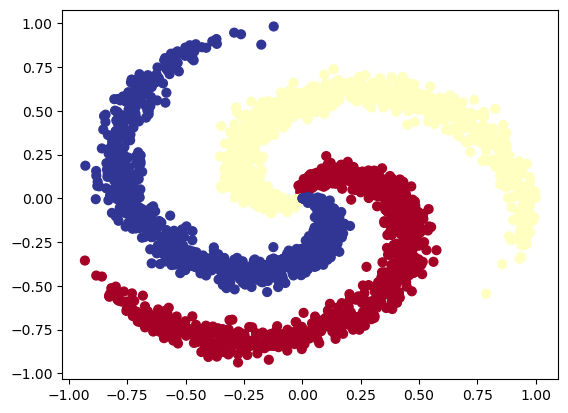

In [14]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 1000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [15]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)
     

(2400, 600, 2400, 600)

In [21]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

class SpiralModel(nn.Module): 
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model_1 = SpiralModel().to(device)
model_1

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [22]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out untrained model outputs
print("Logits:")
print(model_1(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model_1(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model_1(X_train)[:10], dim=1).argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[-0.1974,  0.0622,  0.0872],
        [-0.1973,  0.0491,  0.0813],
        [-0.2224,  0.0461,  0.1128],
        [-0.2225,  0.0753,  0.1563],
        [-0.2283,  0.0164,  0.0969],
        [-0.2258,  0.0470,  0.1431],
        [-0.1992,  0.0235,  0.0685],
        [-0.2229,  0.0895,  0.1589],
        [-0.2784, -0.0777,  0.0973],
        [-0.2147,  0.0397,  0.0898]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.2758, 0.3576, 0.3666],
        [0.2777, 0.3553, 0.3669],
        [0.2698, 0.3529, 0.3773],
        [0.2626, 0.3537, 0.3836],
        [0.2731, 0.3488, 0.3781],
        [0.2660, 0.3494, 0.3846],
        [0.2812, 0.3513, 0.3675],
        [0.2610, 0.3567, 0.3823],
        [0.2719, 0.3323, 0.3958],
        [0.2743, 0.3538, 0.3719]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


In [23]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.02)

from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [24]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1. forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)
  
  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.10 Acc: 0.37 | Test loss: 1.08 Test acc: 0.36
Epoch: 100 | Loss: 0.18 Acc: 0.94 | Test loss: 0.17 Test acc: 0.94
Epoch: 200 | Loss: 0.05 Acc: 0.99 | Test loss: 0.05 Test acc: 0.99
Epoch: 300 | Loss: 0.02 Acc: 1.00 | Test loss: 0.02 Test acc: 1.00
Epoch: 400 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00
Epoch: 500 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00
Epoch: 600 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00
Epoch: 700 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00
Epoch: 800 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00
Epoch: 900 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00


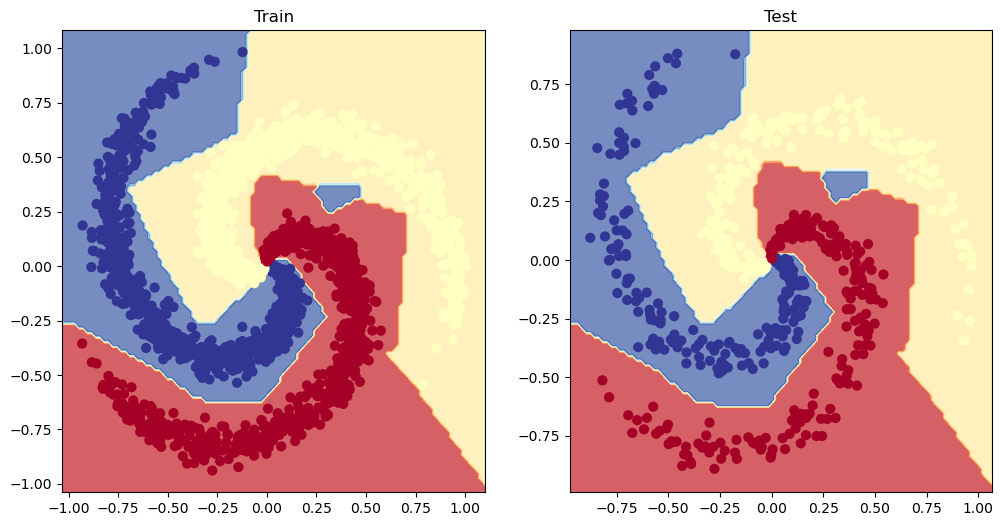

In [25]:
from helper_functions import plot_decision_boundary
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)